In [1]:
%load_ext autoreload
%autoreload 2

# Visualise Ruggedness from generated circuits - exploratory

In [2]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.utils.evolution import calculate_ruggedness_core
from evoscaper.utils.math import arrayise, make_flat_triangle, make_batch_symmetrical_matrices, make_sequence_from_symmetrical
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.visualise import make_sort_hue
from evoscaper.utils.visualise import vis_sampled_histplot
from evoscaper.utils.normalise import calc_minmax
from evoscaper.run.ruggedness import get_perturbations
from common import load_stitch_analytics, load_rugg, make_df_rugg

import itertools
import os
import json
import sys
import numpy as np
import jax

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')


sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.2)
custom_palette = sns.blend_palette(
    ['#ff9f9b', '#ffb482', '#fffea3', '#c1f6b8', '#a0e7e0', '#b9d3ee', '#d6a4ef', '#ff77a7'], n_colors=9)

# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


np.random.seed(0)
PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 02_cvae_verify.ipynb --output=02_cvae_verify_2.ipynb --ExecutePreprocessor.timeout=-1

2025-08-19 17:21:23.332948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755624083.342044  484204 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755624083.344837  484204 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755624083.353622  484204 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755624083.353641  484204 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755624083.353643  484204 computation_placer.cc:177] computation placer alr

[CpuDevice(id=0)]

# Load

In [3]:
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_03_25__12_53_19')
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_07_02__16_52_25')
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_07_03__11_00_50')  # testing
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_07_03__11_20_36')  # testing
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_07_04__14_00_16')  # testing
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_07_04__14_18_54')  # testing
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_07_05__15_10_09')

config_rugg = load_json_as_dict(os.path.join(dir_src_rugg, 'config.json'))
fn_df_hpos_loaded = config_rugg['fn_df_hpos_loaded'].replace('notebooks/', '')
hpos = pd.Series(load_json_as_dict(fn_df_hpos_loaded))
dir_src_nn = os.path.dirname(fn_df_hpos_loaded)
fn_saves = os.path.join(dir_src_nn, [i for i in os.listdir(
    dir_src_nn) if i.startswith('saves')][0])
idx_output = -1

config = {'fn_saves': fn_saves,
          'dir_src_rugg': dir_src_rugg}
top_write_dir = os.path.join(
    'data', '20_visualise_rugged_explore', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)
with open(os.path.join(top_write_dir, 'config.json'), 'w') as f:
    json.dump(config, f)
print('top_write_dir:', top_write_dir)

top_write_dir: data/20_visualise_rugged_explore/2025_08_19__17_21_25


In [4]:
saves_loaded = load_json_as_dict(fn_saves)
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

params = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
params = arrayise(params)

config_bio = load_json_as_dict(config_dataset.filenames_verify_config)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Analytics & Circuits

In [5]:
analytics_rugg = load_stitch_analytics(dir_src_rugg, last_idx=idx_output)

In [6]:
all_fake_circuits = np.load(os.path.join(
    dir_src_rugg, 'all_fake_circuits.npy'))
n_species = all_fake_circuits.shape[-1]

all_sampled_cond = np.load(os.path.join(
    dir_src_rugg, 'sampled_cond', 'sampled_cond_0.npy'))

if config_rugg['perturb_once']:
    eps = np.load('data/ruggedness/2025_07_05__15_10_09/batch_104/eps.npy')
    n_samples = all_fake_circuits.shape[0]
    all_fake_circuits, eps, n_perturbs = get_perturbations(
        make_flat_triangle(all_fake_circuits), config_rugg['eps_perc'], n_samples, config_rugg['n_perturbs'], config_rugg['resimulate_analytics'], config_rugg['perturb_once'])
    all_fake_circuits = make_batch_symmetrical_matrices(all_fake_circuits.reshape(-1, all_fake_circuits.shape[-1]), side_length=n_species)

# Load ys from batches
# fn_ys = os.path.join(dir_src_rugg, 'ys.npy')
# if os.path.exists(fn_ys):
#     ys = np.load(fn_ys)
#     ts = np.load(os.path.join(dir_src_rugg, 'ts.npy'))
# else:
#     batch_dirs = [c for c in os.listdir(dir_src_rugg) if c.startswith('batch')]
#     batch_dirs.sort(key=lambda x: int(x.split('_')[1]))
#     for b in batch_dirs:
#         ys_i = np.load(os.path.join(dir_src_rugg, b, 'ys.npy'))
#         ts = np.load(os.path.join(dir_src_rugg, b, 'ts.npy'))
#         if 'ys' not in locals():
#             ys = ys_i
#             ts_all = ts
#         else:
#             ys = np.concatenate((ys, ys_i), axis=0)
#             ts_all = np.concatenate((ts_all, ts), axis=0)

#     np.save(fn_ys, ys)

# ys_out = ys[..., idx_output]

In [7]:
n_interactions = make_flat_triangle(all_fake_circuits).shape[-1]
n_perturbs = config_bio['n_perturbs'] if not config_rugg['perturb_once'] else n_interactions + config_rugg['resimulate_analytics']


## Calculate Ruggedness

In [8]:
for k in analytics_rugg.keys(): 
    analytics_rugg[k] = analytics_rugg[k].reshape(
        -1, n_perturbs, analytics_rugg[k].shape[-1] if analytics_rugg[k].ndim > 1 else 1)

In [9]:
n_samples = all_fake_circuits.reshape(-1, n_perturbs, *all_fake_circuits.shape[1:]).shape[0]
n_interactions = make_flat_triangle(all_fake_circuits[0]).shape[-1]
n_perturbs = n_interactions + config_rugg['resimulate_analytics']
eps = config_rugg['eps_perc'] * np.abs(all_fake_circuits).max()

ruggedness = {}
for analytic in analytics_rugg.keys():
    ruggedness[analytic] = calculate_ruggedness_core(analytics_rugg, None, analytic,
                                                     config_rugg['resimulate_analytics'], n_samples, n_perturbs, eps)

if config_rugg['resimulate_analytics']:
    # n_max = n_samples * n_perturbs
    analytics_og = {k: np.array(v).reshape(
        n_samples, n_perturbs, -1)[:, -1, :] for k, v in analytics_rugg.items()}
else:
    analytics_og = {}

k_rugg = 'Log ruggedness (adaptation)'

ruggedness[k_rugg] = np.log10(ruggedness['Log sensitivity'])

/tmp/ipykernel_484204/625052940.py:20: RuntimeWarning: divide by zero encountered in log10
  ruggedness[k_rugg] = np.log10(ruggedness['Log sensitivity'])


In [10]:
all_fake_circuits = all_fake_circuits.reshape(-1, n_perturbs, *all_fake_circuits.shape[1:])
ruggedness, analytics_og, n_samples, n_perturbs, n_interactions, eps, k_rugg = load_rugg(all_fake_circuits, config_rugg, analytics_rugg)

/workdir/notebooks/common.py:222: RuntimeWarning: divide by zero encountered in log10
  ruggedness[k_rugg] = np.log10(ruggedness['Log sensitivity'])


In [ ]:
df_rugg = make_df_rugg(analytics_og, ruggedness, idx_output, all_sampled_cond,
                       y_datanormaliser, y_methods_preprocessing, config_dataset, k_rugg)

y_methods_preprocessing_mod = [
    l for l in y_methods_preprocessing if l != 'robust_scaling']
for k in ['adaptation', 'Log ruggedness (adaptation)']:
    df_rugg[f'{k} norm'] = calc_minmax(
        df_rugg[k].values, min_val=data[k].min(), scale=data[k].max() - data[k].min(),
        max_range=1, min_range=0)
    data[f'{k} norm'] = calc_minmax(
        data[k].values, min_val=data[k].min(), scale=data[k].max() - data[k].min(),
        max_range=1, min_range=0)
    df[f'{k} norm'] = calc_minmax(
        df[k].values, min_val=data[k].min(), scale=data[k].max() - data[k].min(),
        max_range=1, min_range=0)
    # df_rugg[f'{k} norm'] = y_datanormaliser.create_chain_preprocessor(
    #     y_methods_preprocessing_mod)(df_rugg[f'{k}'].values, col=k, use_precomputed=True)
    # data[f'{k} norm'] = y_datanormaliser.create_chain_preprocessor(
    #     y_methods_preprocessing_mod)(data[f'{k}'].values, col=k, use_precomputed=True)

data['Log ruggedness (adaptation) bin'] = pd.cut(
    data['Log ruggedness (adaptation)'], bins=10)
data['Log ruggedness (adaptation) bin'] = data['Log ruggedness (adaptation) bin'].apply(
    lambda x: x.mid).astype(float).round(2)

sampled_rugg = all_sampled_cond[...,
                                config_dataset.objective_col.index(k_rugg)]
rugg_k = ruggedness[k_rugg]
sampled_rugg = y_datanormaliser.create_chain_preprocessor_inverse(
    y_methods_preprocessing)(sampled_rugg, col=k_rugg)

/workdir/notebooks/common.py:244: RuntimeWarning: divide by zero encountered in log10
  ruggedness[col_rugg][..., idx_output] == 0, np.nan, np.log10(ruggedness[col_rugg][..., idx_output]))
/workdir/notebooks/common.py:244: RuntimeWarning: divide by zero encountered in log10
  ruggedness[col_rugg][..., idx_output] == 0, np.nan, np.log10(ruggedness[col_rugg][..., idx_output]))
/workdir/notebooks/common.py:244: RuntimeWarning: divide by zero encountered in log10
  ruggedness[col_rugg][..., idx_output] == 0, np.nan, np.log10(ruggedness[col_rugg][..., idx_output]))


# Visualise

category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
/tmp/ipykernel_484204/2547156275.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x=sampled_rugg.flatten(),
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


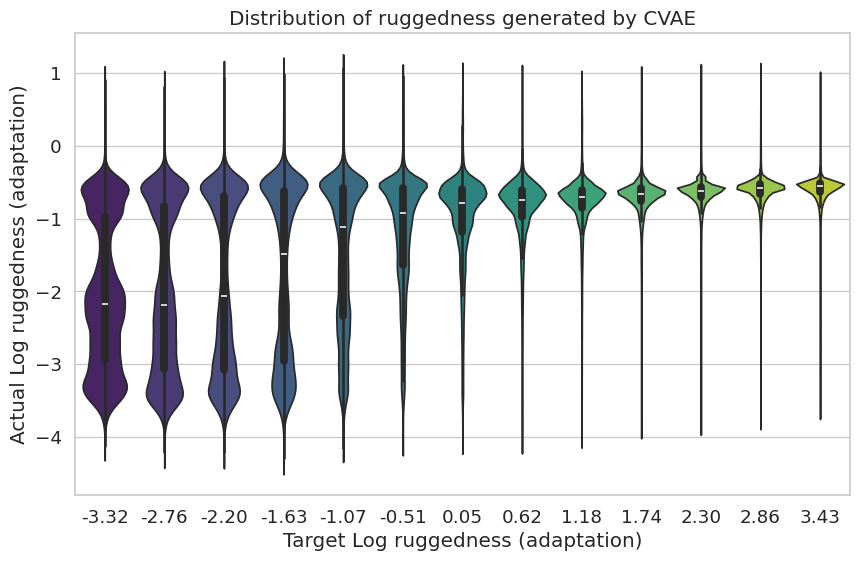

In [12]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x=sampled_rugg.flatten(), 
                    y=rugg_k[..., idx_output], palette='viridis')

plt.xlabel(f'Target {k_rugg}')
plt.xticks(ax.get_xticks(), [f'{i:.2f}' for i in np.unique(
    sampled_rugg.flatten()).round(2)])
plt.ylabel(f'Actual {k_rugg}')
plt.title('Distribution of ruggedness generated by CVAE')
plt.savefig(os.path.join(top_write_dir, 'ruggedness_violin.png'),
            dpi=300, bbox_inches='tight', transparent=True)

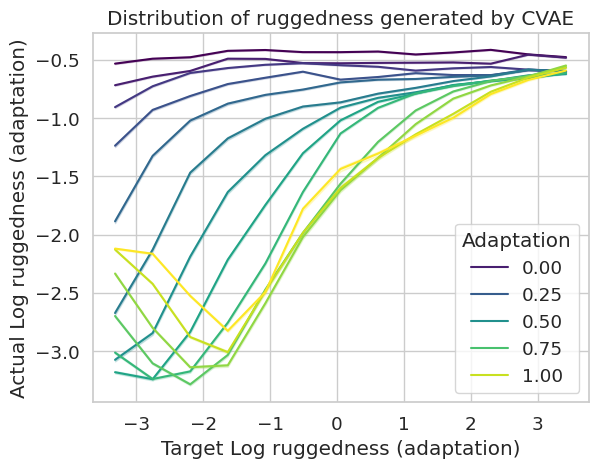

In [13]:
hue = all_sampled_cond[..., config_dataset.objective_col.index(
    'adaptation')].flatten()
df_plot = pd.DataFrame()
df_plot[f'Target {k_rugg}'] = sampled_rugg.flatten()
df_plot[f'Actual {k_rugg}'] = rugg_k[..., idx_output]
df_plot['Adaptation'] = all_sampled_cond[...,
                                         config_dataset.objective_col.index('adaptation')].flatten().round(2)
# plt.figure(figsize=(10, 6))
ax = sns.lineplot(df_plot, x=f'Target {k_rugg}', y=f'Actual {k_rugg}',
                  hue='Adaptation', palette='viridis')

plt.title('Distribution of ruggedness generated by CVAE')
plt.savefig(os.path.join(top_write_dir, 'ruggedness_lineplot.png'),
            dpi=300, bbox_inches='tight', transparent=True)

## Conditional plots

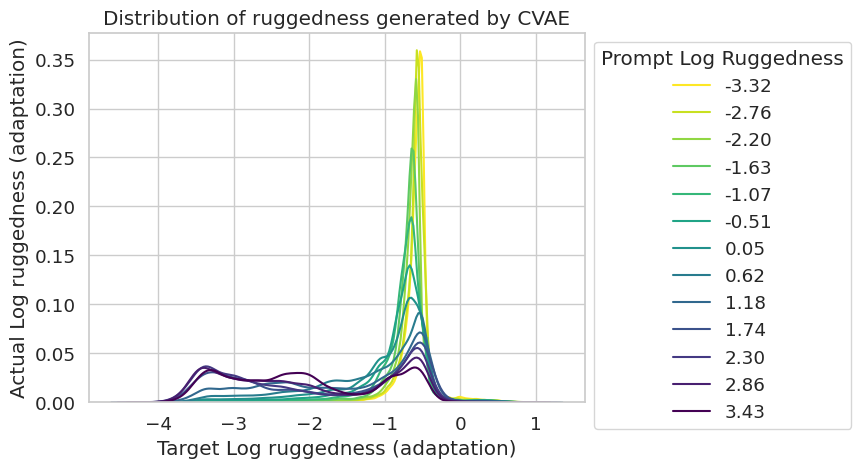

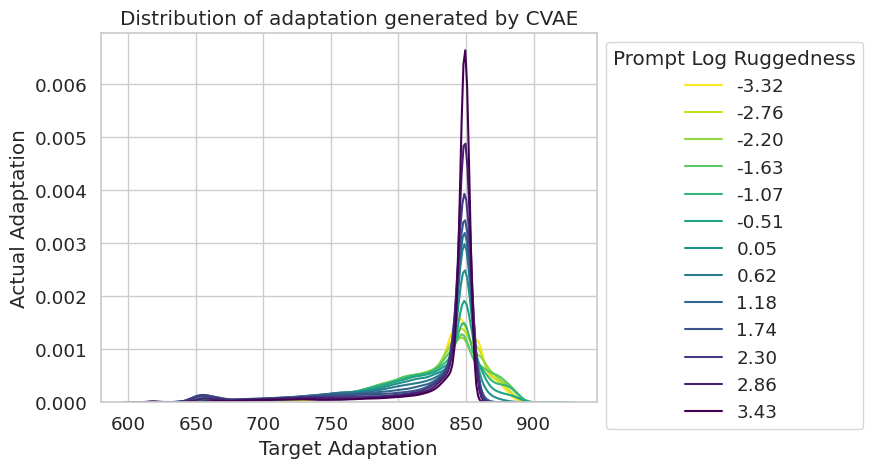

In [14]:
plt.figure()
ax = sns.kdeplot(x=rugg_k[..., idx_output],
                 hue=sampled_rugg.flatten(), palette='viridis')
plt.xlabel(f'Target {k_rugg}')
plt.ylabel(f'Actual {k_rugg}')
plt.title('Distribution of ruggedness generated by CVAE')
leg_text = [f'{ii:.2f}' for ii in np.unique(sampled_rugg.flatten())]
plt.legend(leg_text, title='Prompt Log Ruggedness')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(top_write_dir, 'ruggedness_kde.png'),
            dpi=300, bbox_inches='tight', transparent=True)


plt.figure()
ax = sns.kdeplot(x=analytics_og['adaptation'][..., idx_output],
                 hue=sampled_rugg.flatten().round(2), palette='viridis')

plt.xlabel(f'Target Adaptation')
plt.ylabel(f'Actual Adaptation')
plt.title('Distribution of adaptation generated by CVAE')
leg_text = [f'{ii:.2f}' for ii in np.unique(sampled_rugg.flatten())]
plt.legend(leg_text, title='Prompt Log Ruggedness')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(top_write_dir, 'adapt_kde.png'),
            dpi=300, bbox_inches='tight', transparent=True)

In [15]:
n_species = 3
output_species = ['RNA_2', 'RNA_3']
all_species = [str(i) for i in range(rugg_k.shape[-1] -
                                     n_species)] + ['RNA_1'] + output_species
# norm_rugg_k = norm_rugg(
#     rugg_k, df['Log ruggedness (adaptation)'].values, y_datanormaliser,
#     min_range=all_sampled_cond.min(), max_range=all_sampled_cond.max())

vis_sampled_histplot(rugg_k, all_species, output_species, all_sampled_cond[..., config_dataset.objective_col.index(k_rugg)].reshape(-1, 1),  # c,
                     title=f'Ruggedness of generated circuits', x_label=f'$Log_{{10}}$ Ruggedness', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'kde_rugg.png'),
                     f=sns.kdeplot, log_scale=[False, False], fill=False, include_hue_vlines=True, vline_uniqs=np.unique(sampled_rugg.flatten()),
                     hue_label='Prompt', figsize=(17, 6.5), output_idx=idx_output)

vis_sampled_histplot(df_rugg["Log ruggedness (adaptation) norm"].values[:, None], all_species, output_species, 
                     all_sampled_cond[..., config_dataset.objective_col.index(k_rugg)].reshape(-1, 1),  # c,
                     title=f'Ruggedness of generated circuits', x_label=f'$Log_{{10}}$ Ruggedness', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'kde_rugg_norm.png'),
                     f=sns.kdeplot, log_scale=[False, False], fill=False, include_hue_vlines=True, 
                     vline_uniqs=np.unique(all_sampled_cond[..., config_dataset.objective_col.index(k_rugg)].flatten()),
                     hue_label='Prompt', figsize=(17, 6.5), output_idx=idx_output)

Now high adaptation and normalised ruggedness

In [16]:
sampled_adapt = all_sampled_cond[...,
                                 config_dataset.objective_col.index('adaptation')]
# idxs_adapt = np.where(sampled_adapt.flatten() >= 0.7 * sampled_adapt.max())

for label, idxs_adapt in zip(['hiadapt', 'adapt1'], [
    np.where(sampled_adapt.flatten() >= 0.7 * sampled_adapt.max()),
    np.where(sampled_adapt.flatten() >= 0.7 * 1)
]):
    vis_sampled_histplot(rugg_k[idxs_adapt], all_species, output_species,
                         all_sampled_cond[..., config_dataset.objective_col.index(
                             k_rugg)].reshape(-1, 1)[idxs_adapt],
                         title=f'Ruggedness of generated circuits', x_label=f'$Log_{{10}}$ Ruggedness', multiple='layer',
                         show=False, save_path=os.path.join(top_write_dir, f'kde_rugg_{label}.png'),
                         f=sns.kdeplot, log_scale=[False, False], fill=False, include_hue_vlines=True, vline_uniqs=np.unique(sampled_rugg.flatten()),
                         hue_label='Prompt', figsize=(17, 6.5), output_idx=idx_output)

    vis_sampled_histplot(df_rugg["Log ruggedness (adaptation) norm"].values[:, None][idxs_adapt], all_species, output_species,
                         all_sampled_cond[..., config_dataset.objective_col.index(
                             k_rugg)].reshape(-1, 1)[idxs_adapt],
                         title=f'Ruggedness of generated circuits', x_label=f'$Log_{{10}}$ Ruggedness', multiple='layer',
                         show=False, save_path=os.path.join(top_write_dir, f'kde_rugg_{label}_norm.png'),
                         f=sns.kdeplot, log_scale=[False, False], fill=False, include_hue_vlines=True,
                         vline_uniqs=np.unique(
                             all_sampled_cond[..., config_dataset.objective_col.index(k_rugg)].flatten()),
                         hue_label='Prompt', figsize=(17, 6.5), output_idx=idx_output)

# KDE + Training Data


In [ ]:
# binned_data_samples_other

array([3.4252496, 3.4252496, 3.4252496, ..., 3.4252496, 3.4252496,
       3.4252496], dtype=float32)

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:1196: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  x_visible = any(t.get_visible() for t in ax.get_xticklabels())
/tmp/ipykernel_484204/2271795563.py:85: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[1, i].set_ylim(0, count_max)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:1196: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  x_visible = any(t.get_visible() for t in ax.get_xticklabels())
/tmp/ipykernel_484204/2271795563.py:85: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[1, i].set_ylim(0, count_max)


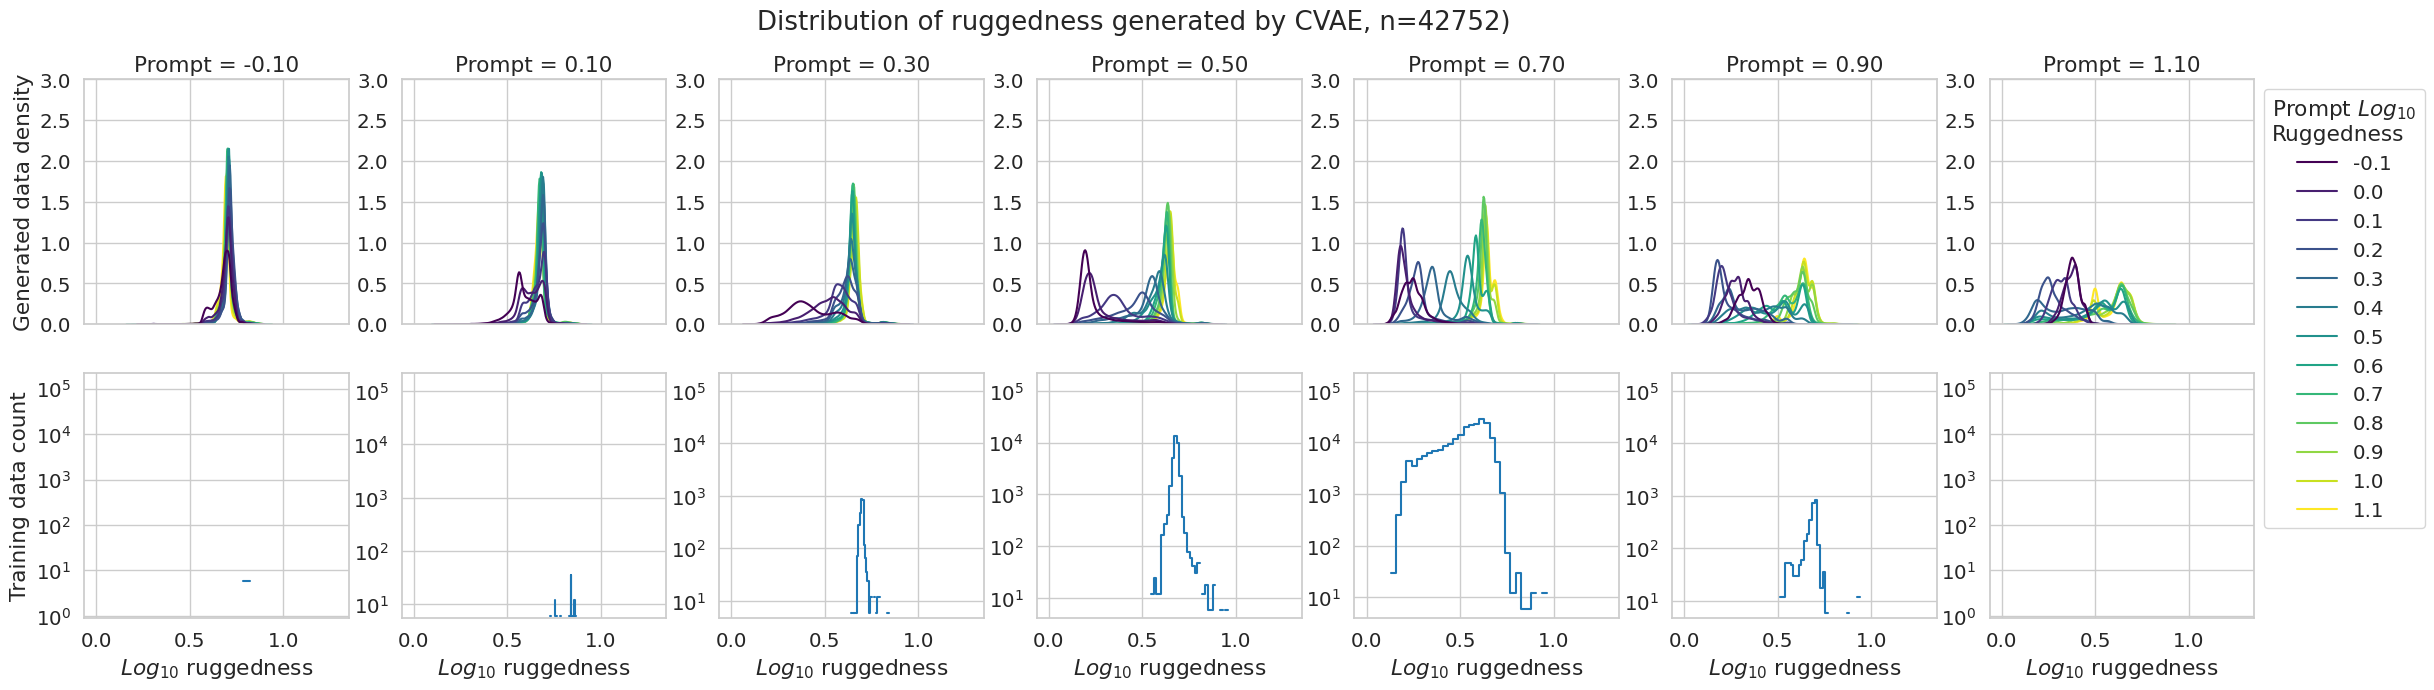

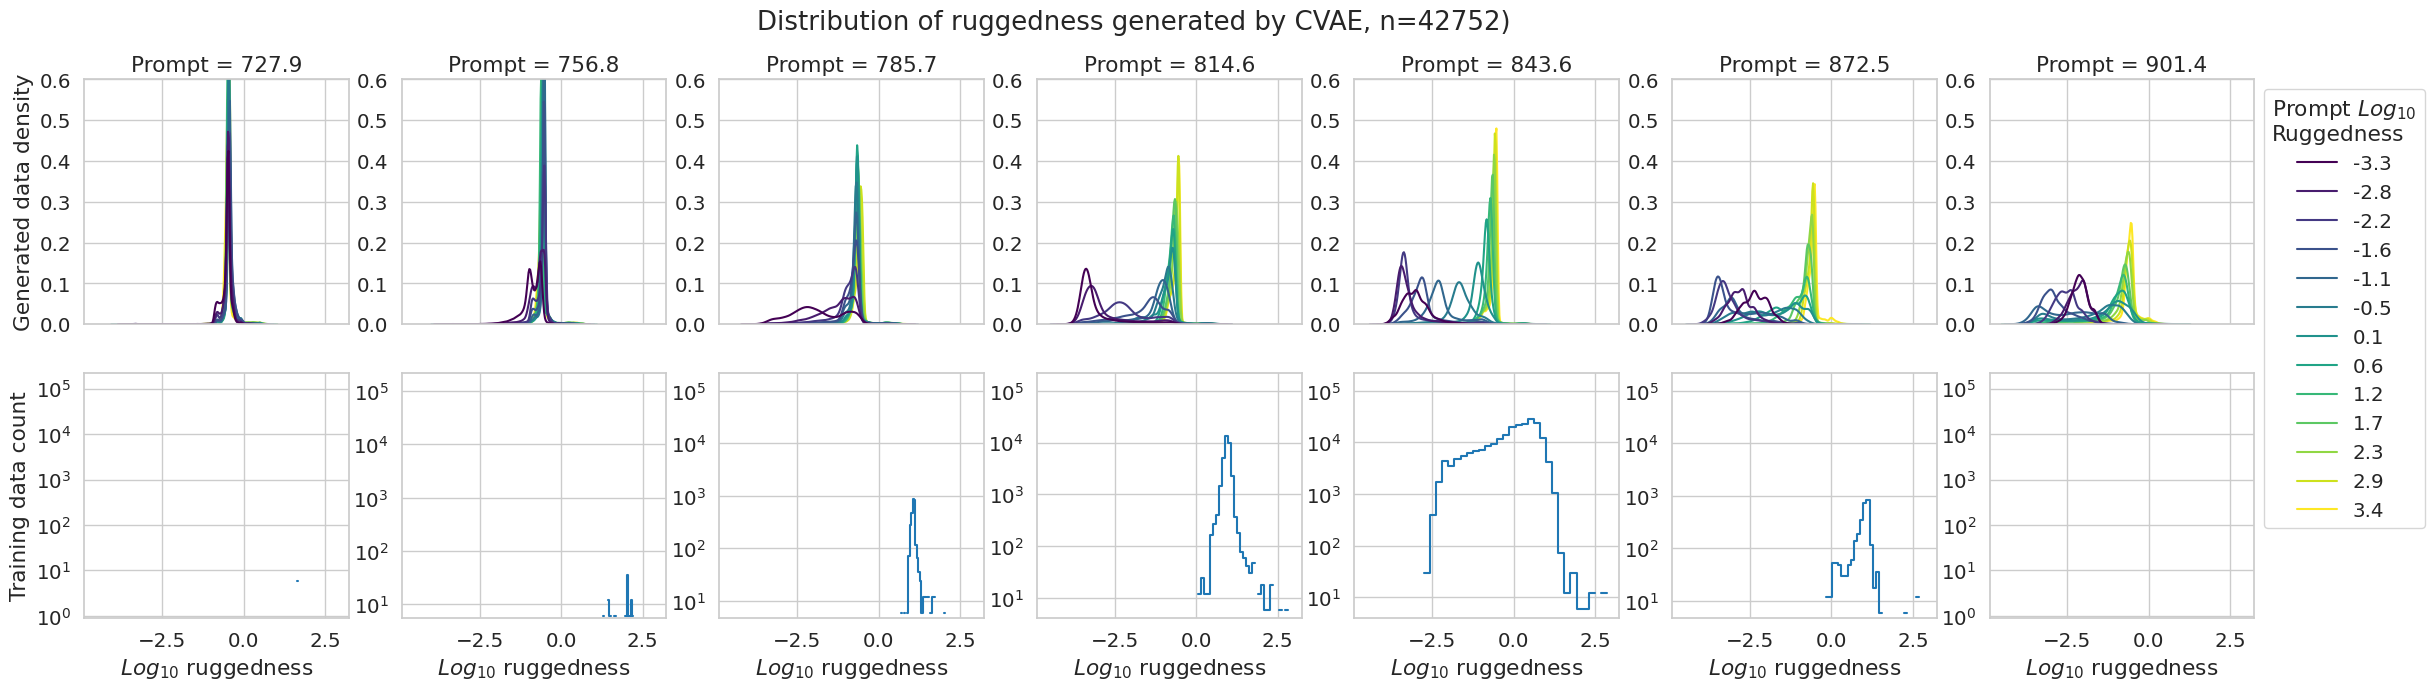

In [62]:
sns.set_context('notebook', font_scale=1.3)

if len(config_dataset.objective_col) == 2:

    k_other = 'adaptation'
    k_other_idx = config_dataset.objective_col.index(k_other)
    sampled_rev = y_datanormaliser.create_chain_preprocessor_inverse(
        y_methods_preprocessing)(all_sampled_cond[..., k_other_idx], col=k_other)

    uniq_sampled_other = np.array(sorted(np.unique(sampled_rev)))
    uniq_sampled_other_half = uniq_sampled_other[::2]

    # filt_samp = data['sample_name'] == 'RNA_2'
    # binned_data_samples_other = np.array(list(map(lambda x: uniq_sampled_other_half[x], np.argmin(
    #     np.abs(data[filt_samp][k_other].values[None, :] - uniq_sampled_other_half[:, None]), axis=0))))
    # binned_data_samples_rugg = np.array(list(map(lambda x: np.unique(sampled_rugg.flatten())[x], np.argmin(
    #     np.abs(data[filt_samp][k_rugg].values[None, :] - np.unique(sampled_rugg.flatten())[:, None]), axis=0))))
    binned_data_samples_other = uniq_sampled_other_half[np.argmin(np.abs(df[k_other].values[None, :] - uniq_sampled_other_half[:, None]), axis=0)]
    binned_data_samples_rugg = np.unique(sampled_rugg.flatten())[np.argmin(np.abs(df[k_other].values[None, :] - np.unique(sampled_rugg.flatten())[:, None]), axis=0)]
    # rugg_k_rev = y_datanormaliser.create_chain_preprocessor(
    #     y_methods_preprocessing)(rugg_k[..., idx_output], col=k_rugg, use_precomputed=True)
    rugg_k_rev = df_rugg["Log ruggedness (adaptation) norm"].values
    df_xbinned = pd.DataFrame()
    df_xbinned[k_other] = binned_data_samples_other
    df_xbinned[k_rugg] = df[k_rugg].values
    df_xbinned[x_cols] = df[x_cols].values
    df_xbinned[k_rugg + ' (normalized)'] = df[k_rugg + ' norm'].values
    # df_xbinned[k_rugg + ' (normalized)'] = y_datanormaliser.create_chain_preprocessor(
    #     y_methods_preprocessing)(df_xbinned[k_rugg].values, col=k_rugg, use_precomputed=True)

    nrows = 2
    ncols = len(uniq_sampled_other_half)

    for inc, use_norm_cond in enumerate([True, False]):

        if use_norm_cond:
            x_plot = rugg_k_rev
            hue = all_sampled_cond[..., config_dataset.objective_col.index(
                k_rugg)].flatten()
            k_rugg_curr = k_rugg + ' (normalized)'
        else:
            x_plot = rugg_k[..., idx_output]
            hue = sampled_rugg.flatten().round(1)
            k_rugg_curr = k_rugg

        leg_text = [f'{ii:.2f}' for ii in np.unique(sampled_rugg.flatten())]
        fig, axs = plt.subplots(nrows, ncols, figsize=(
            4*ncols, 3.5*nrows), sharex=True)  # , sharey=True)
        for i, v0 in enumerate(uniq_sampled_other_half):
            idxs_sampled0 = np.where(sampled_rev.flatten() == v0)[0]
            g = sns.kdeplot(x=x_plot[idxs_sampled0],
                            hue=hue[idxs_sampled0], palette='viridis', ax=axs.flat[i])
            axs.flat[i].set_xlabel(f'{k_rugg_curr}')
            if use_norm_cond:
                axs.flat[i].set_title(
                    f'Prompt = {np.unique(all_sampled_cond[..., k_other_idx])[i*2]:.2f}')
            else:
                axs.flat[i].set_title(
                    f'Prompt = {v0:.1f}')
            if i == (len(uniq_sampled_other_half) - 1):
                legend = g.legend_
                if legend:
                    for text in legend.get_texts():
                        text.set_text(f"{float(text.get_text()):.1f}")
                sns.move_legend(g, "upper left", bbox_to_anchor=(
                    1, 1), title=f'Prompt $Log_{{10}}$\nRuggedness')
            else:
                axs.flat[i].get_legend().remove()
            axs[0, i].set_ylim(0, 3 if use_norm_cond else 0.6)
            axs[0, i].set_ylabel('')
        axs[0, 0].set_ylabel('Generated data density')

        d = pd.melt(df_xbinned, id_vars=[
                    k_other, k_rugg_curr], value_vars=x_cols, value_name='Input x', var_name='X type')
        count_max = 1
        for i, v0 in enumerate(uniq_sampled_other_half):
            sns.histplot(d[d[k_other] == v0], x=k_rugg_curr, bins=30, ax=axs[1, i], log_scale=[
                         False, True], element='step', fill=False)
            # sns.histplot(d[d[k_other] == v0], x='adaptation', bins=30, ax=axs[1, i], log_scale=[False, True], element='step', fill=False)
            count_max = np.max([count_max, d[d[k_other] == v0].shape[0]])
            axs[1, i].set_ylabel('')
            axs[1, i].set_xlabel(r'$Log_{10}$ ruggedness')
        axs[1, 0].set_ylabel('Training data count')
        for i in range(ncols):
            axs[1, i].set_ylim(0, count_max)

        plt.suptitle(
            f'Distribution of ruggedness generated by CVAE, n={len(df_xbinned)})')
        # plt.tight_layout()
        plt.savefig(os.path.join(top_write_dir, f'ruggedness_by_prompt_{inc}.png'),
                    dpi=300, bbox_inches='tight', transparent=True)

# Sensitivity vs. Precision

In [18]:
idxs_show = make_sort_hue(df_rugg[df_rugg['Log ruggedness (adaptation) bin'] > -1]
                          ['Log ruggedness (adaptation) bin'].round(2), sort=True, sort_random=False, sort_flip_prop=4)

# g = sns.jointplot(df_rugg[df_rugg['Log ruggedness (adaptation) bin'] > -1].iloc[idxs_show],
#                   x='Log sensitivity', y='Log precision',
#                   hue='Log ruggedness (adaptation) bin',
#                   alpha=0.5, palette='viridis')
# plt.xlabel(r'$Log_{10}$ sensitivity')
# plt.ylabel(r'$Log_{10}$ precision')
# l = plt.legend(title=r'$Log_{10}$ Ruggedness')
# for line in l.get_lines():
#     line.set(alpha=1.0)
# plt.savefig(os.path.join(top_write_dir, 'sp_jointplot.png'),
#             dpi=300, bbox_inches='tight', transparent=True)

In [19]:
# idxs_show = make_sort_hue(data[data['Log ruggedness (adaptation) bin'] > -1]
#                           ['Log ruggedness (adaptation) bin'].round(2), sort=True, sort_random=False, sort_flip_prop=4)

# sns.jointplot(data[data['Log ruggedness (adaptation) bin'] > -1].iloc[idxs_show],
#               x='Log sensitivity', y='Log precision',
#               hue='Log ruggedness (adaptation) bin',
#               alpha=0.5, palette='viridis')
# plt.xlabel(r'$Log_{10}$ sensitivity')
# plt.ylabel(r'$Log_{10}$ precision')
# plt.legend(title=r'$Log_{10}$ Ruggedness')
# plt.savefig(os.path.join(top_write_dir, 'sp_jointplot_training.png'),
#             dpi=300, bbox_inches='tight', transparent=True)

# Ruggedness vs. Adaptation

In [20]:
df_rugg['Is adaptable'] = False
df_rugg['Is adaptable og'] = False
df_rugg.loc[(df_rugg['Log sensitivity'] > 0) & (df_rugg['Log precision'] > 1),
            'Is adaptable og'] = True  # np.nanmax(df_rugg['Adaptation bin']) + 20
df_rugg.loc[df_rugg['adaptation'] > 870, 'Is adaptable'] = True

data['Is adaptable'] = False
data['Is adaptable og'] = False
data.loc[(data['Log sensitivity'] > 0) & (data['Log precision'] > 1),
         'Is adaptable og'] = True  # np.nanmax(data['Adaptation bin']) + 20
# np.nanmax(data['Adaptation bin']) + 20
data.loc[data['adaptation'] > 870, 'Is adaptable'] = True

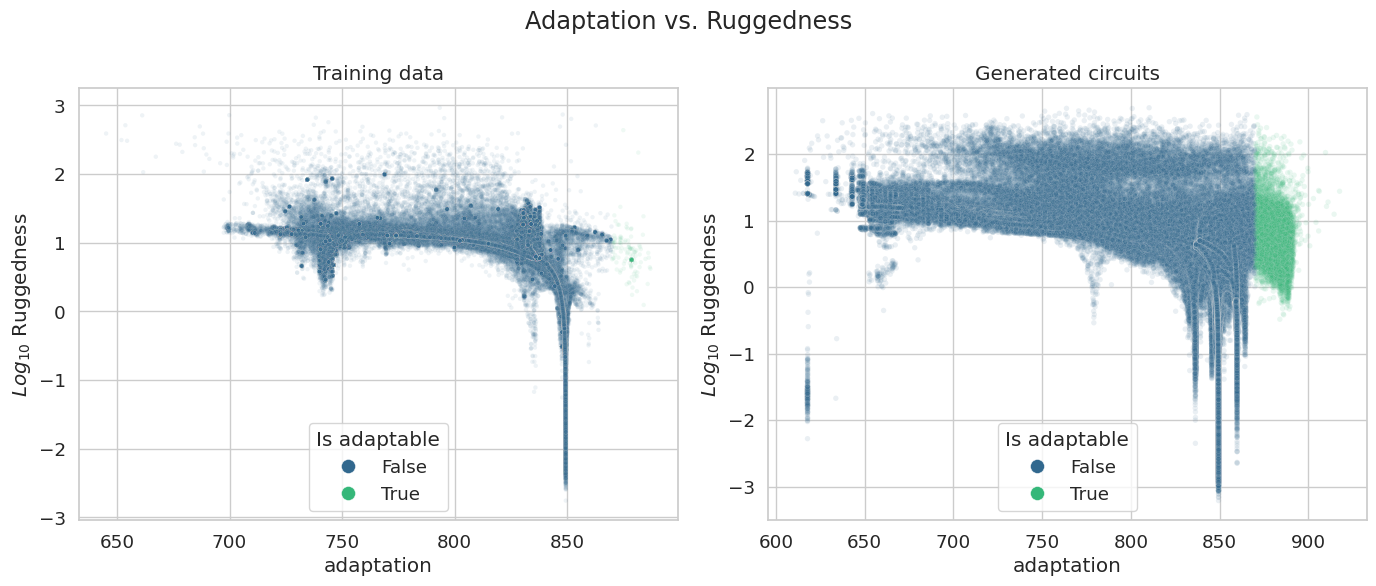

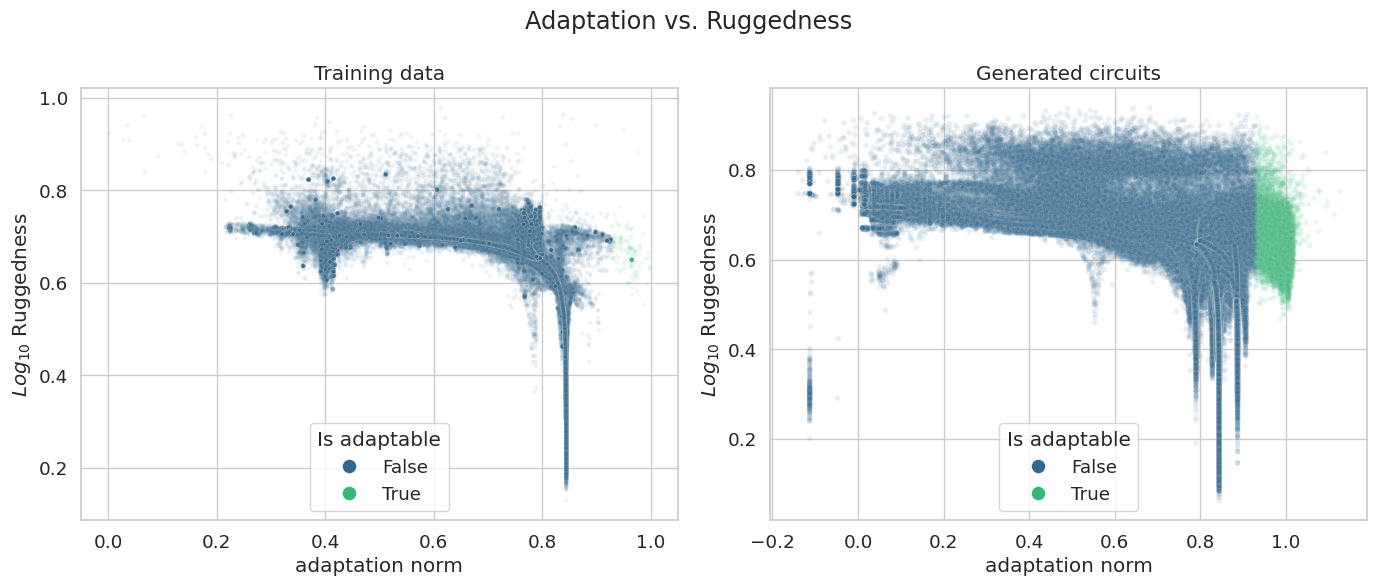

In [21]:
hue = 'initial_steady_states'
hue = 'steady_states'
hue = 'Is adaptable'
# hue = 'Is adaptable og'

sns.set_context('notebook', font_scale=1.2)

df_rugg['fold_change'] = analytics_og['fold_change'][..., idx_output]

def adjust_legend(g, hue):
    for line in g.legend().get_lines():
        line.set(alpha=1.0, markersize=10)
    g.legend_.set_title(hue)
    sns.move_legend(g, "lower center", title=hue)

for norm_setting in ['unnormalised', 'normalised']:
    if norm_setting == 'normalised':
        x_col = 'adaptation norm'
        y_col = 'Log ruggedness (adaptation) norm'
    else:
        x_col = 'adaptation'
        y_col = 'Log ruggedness (adaptation)'
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    g = sns.scatterplot(data[data['sample_name'] == 'RNA_2'], #.sort_values(by=hue), 
                        x=x_col, y=y_col,
                        hue=hue, alpha=0.08,
                        palette='viridis', s=10, ax=axs[0], legend=True)
    axs[0].set_title('Training data')
    axs[0].set_ylabel(r'$Log_{10}$ Ruggedness')
    adjust_legend(g, hue)

    g = sns.scatterplot(df_rugg, #.sort_values(by=hue), 
                        x=x_col, y=y_col,
                        hue=hue, alpha=0.1,
                        palette='viridis', s=15, ax=axs[1])
    axs[1].set_title('Generated circuits')
    axs[1].set_ylabel(r'$Log_{10}$ Ruggedness')
    adjust_legend(g, hue)

    plt.suptitle('Adaptation vs. Ruggedness')
    plt.tight_layout()
    plt.savefig(os.path.join(
        top_write_dir, f'adaptation_ruggedness{"_norm" if norm_setting == "normalised" else ""}.png'), dpi=300, bbox_inches='tight', transparent=True)


In [22]:
# hue = 'Is adaptable'
# x_col = 'adaptation norm'
# y_col = 'Log ruggedness (adaptation) norm'

# g = sns.jointplot(data[data['sample_name'] == 'RNA_2'].sort_values(by=hue), x=x_col, y=y_col,
#                   hue=hue, alpha=0.08,
#                   palette='viridis', s=15, legend=True,
#                   height=8, ratio=5)

# # Adjust legend
# for line in g.ax_joint.legend().get_lines():
#     line.set(alpha=1.0, markersize=10)
# g.ax_joint.legend_.set_title(hue)
# sns.move_legend(g.ax_joint, "lower center", title=hue)

# plt.suptitle('Adaptation vs. Ruggedness')
# plt.tight_layout()
# plt.savefig(os.path.join(
#     top_write_dir, f'adaptation_ogdata_joint_norm.png'), dpi=300, bbox_inches='tight', transparent=True)

/tmp/ipykernel_374992/2457189040.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


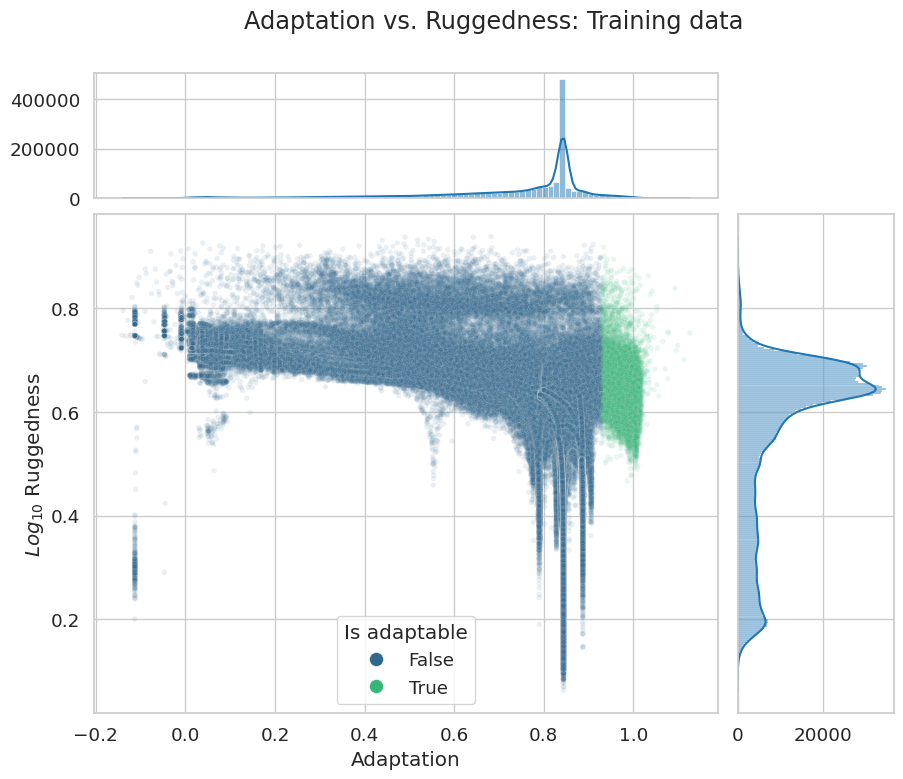

In [23]:
# SAME AS JOINT PLOT, BUT MANUAL

# Create a figure with a GridSpec for the scatter plot and histograms
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Add subplots to the GridSpec
ax_scatter = fig.add_subplot(gs[1, 0])
ax_hist_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_hist_y = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Plot scatterplot
# xcol_data = cond[..., config_dataset.objective_col.index(
#     'adaptation')].flatten()
# ycol_data = cond[..., config_dataset.objective_col.index(k_rugg)].flatten()
# xcol_data = data[(data['sample_name'] == 'RNA_2') & (data[x_col] <= 1)].sort_values(by=hue)[x_col].values
# ycol_data = data[(data['sample_name'] == 'RNA_2') & (data[x_col] <= 1)].sort_values(by=hue)[y_col].values
xcol_data = df_rugg[x_col].values
ycol_data = df_rugg[y_col].values
g = sns.scatterplot(x=xcol_data, y=ycol_data,
                    hue=df_rugg[hue].values, 
                    alpha=0.1,
                    palette='viridis', s=15, ax=ax_scatter)

# Plot histograms
sns.histplot(x=xcol_data, ax=ax_hist_x, kde=True, legend=False, bins=100)
sns.histplot(y=ycol_data, ax=ax_hist_y, kde=True, legend=False) #, bins=30)

# Set titles and labels
ax_scatter.set_xlabel('Adaptation')
ax_scatter.set_ylabel(r'$Log_{10}$ Ruggedness')
ax_hist_x.tick_params(axis='x', labelbottom=False)
ax_hist_y.tick_params(axis='y', labelleft=False)

# Remove labels from the histograms
ax_hist_x.set(ylabel='', xlabel='')
ax_hist_y.set(xlabel='', ylabel='')

# Adjust legend
for line in g.legend().get_lines():
    line.set(alpha=1.0, markersize=10)
g.legend_.set_title(hue)
sns.move_legend(g, "lower center", title=hue)

plt.suptitle('Adaptation vs. Ruggedness: Training data')
plt.tight_layout()
plt.savefig(os.path.join(
    top_write_dir, f'adaptation_rugg_wkde_norm.png'), dpi=300, bbox_inches='tight', transparent=True)
    # top_write_dir, f'adaptation_ogdata_wkde_norm.png'), dpi=300, bbox_inches='tight', transparent=True)

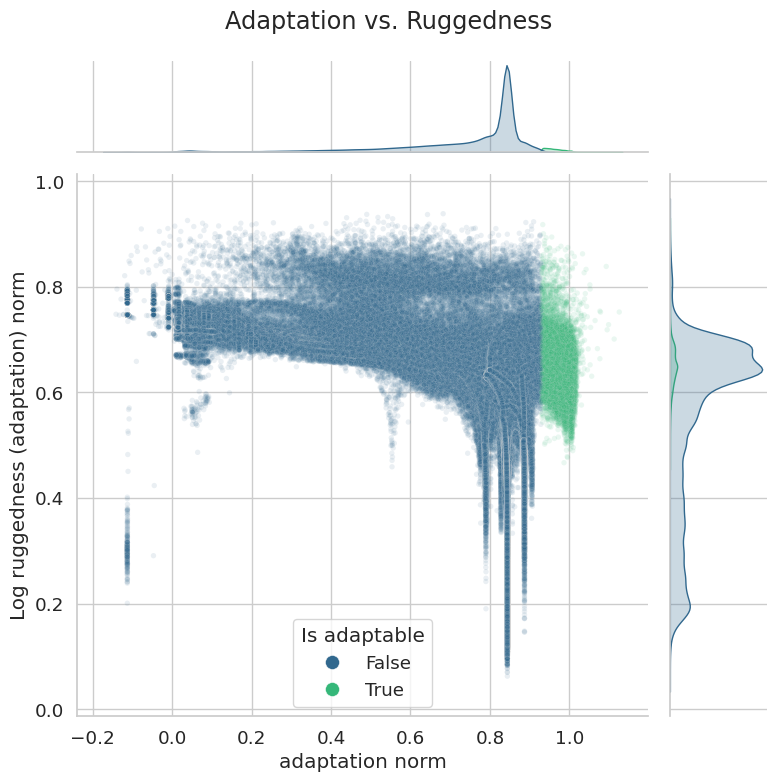

In [24]:
hue = 'Is adaptable'
# hue = 'Is adaptable og'


for norm_setting in ['normalised', 'unnormalised']:
    if norm_setting == 'normalised':
        x_col = 'adaptation norm'
        y_col = 'Log ruggedness (adaptation) norm'
    else:
        x_col = 'adaptation'
        y_col = 'Log ruggedness (adaptation)'

    g = sns.jointplot(df_rugg, #.sort_values(by=hue), 
                      x=x_col, y=y_col,
                      hue=hue, alpha=0.1,
                      palette='viridis', s=15,
                      height=8, ratio=5)
    
    # Adjust legend
    for line in g.ax_joint.legend().get_lines():
        line.set(alpha=1.0, markersize=10)
    g.ax_joint.legend_.set_title(hue)
    sns.move_legend(g.ax_joint, "lower center", title=hue)

    plt.suptitle('Adaptation vs. Ruggedness')
    plt.tight_layout()
    plt.savefig(os.path.join(
        top_write_dir, f'adaptation_rugg_joint{"_norm" if norm_setting == "normalised" else ""}.png'), dpi=300, bbox_inches='tight', transparent=True)
    
    break

/tmp/ipykernel_374992/2152779484.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


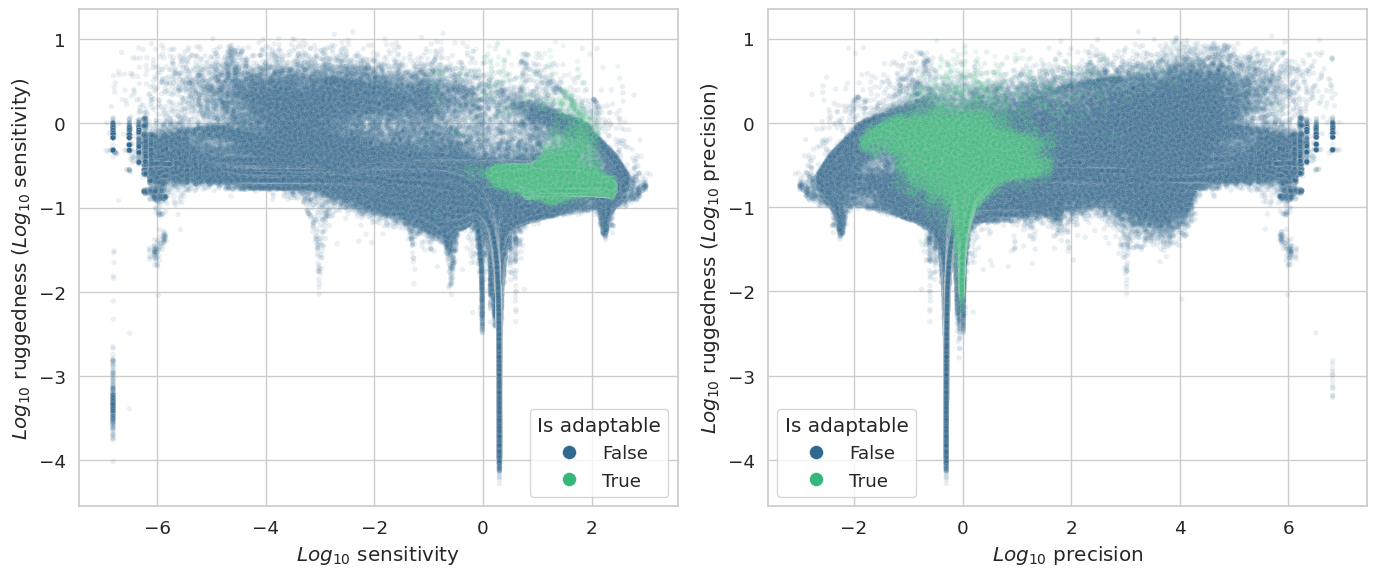

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
for i, y_col in enumerate(['Log ruggedness (Log sensitivity)', 'Log ruggedness (Log precision)']):
    x_col = y_col.split('(')[-1].strip('()')
    g = sns.scatterplot(df_rugg.sort_values(by='Is adaptable'), x=x_col, y=y_col,
                        hue='Is adaptable', alpha=0.1,
                        palette='viridis', s=15, ax=axs[i], legend=True)

    for line in g.legend().get_lines():
        line.set(alpha=1.0, markersize=10)
    g.legend_.set_title('Is adaptable')
    # axs[i].set_title('Training data')
    axs[i].set_xlabel(x_col.replace('Log', r'$Log_{10}$'))
    axs[i].set_ylabel(y_col.replace('Log', r'$Log_{10}$'))

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'ruggedness_sensitivity_precision.png'),
            dpi=300, bbox_inches='tight', transparent=True)

/tmp/ipykernel_374992/2676823370.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_374992/2676823370.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(top_write_dir, 'ruggedness_sensitivity_precision_og.png'),
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


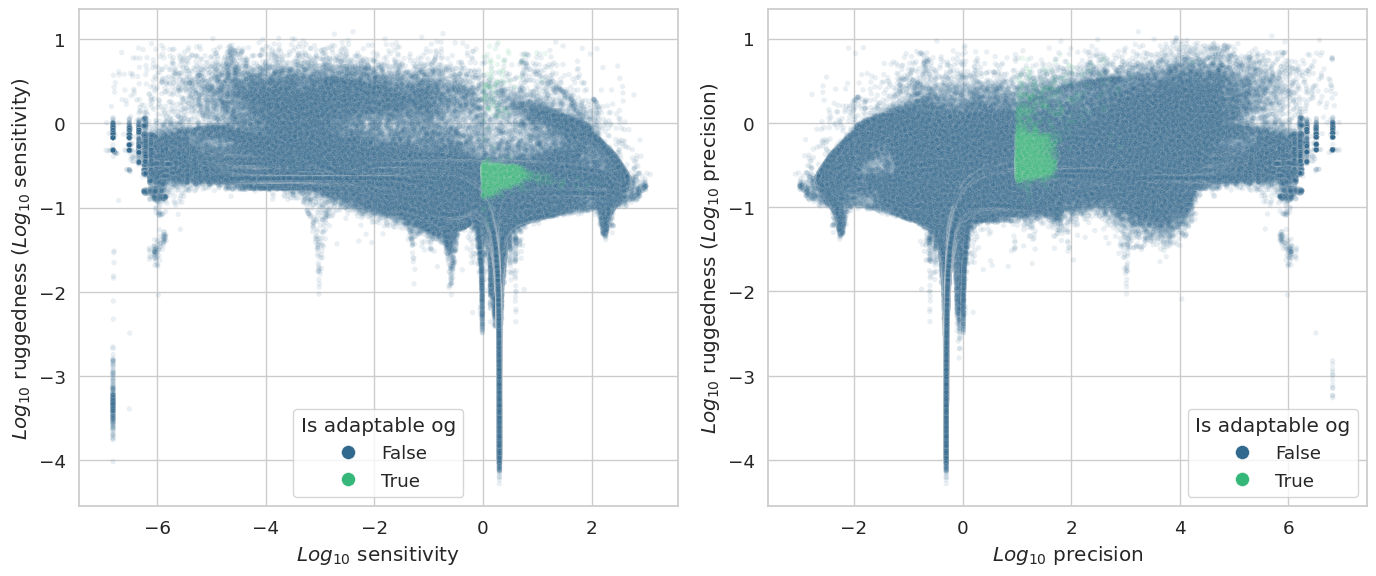

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
for i, y_col in enumerate(['Log ruggedness (Log sensitivity)', 'Log ruggedness (Log precision)']):
    x_col = y_col.split('(')[-1].strip('()')
    g = sns.scatterplot(df_rugg.sort_values(by='Is adaptable og'), x=x_col, y=y_col,
                        hue='Is adaptable og', alpha=0.1,
                        palette='viridis', s=15, ax=axs[i], legend=True)

    for line in g.legend().get_lines():
        line.set(alpha=1.0, markersize=10)
    g.legend_.set_title('Is adaptable og')
    # axs[i].set_title('Training data')
    axs[i].set_xlabel(x_col.replace('Log', r'$Log_{10}$'))
    axs[i].set_ylabel(y_col.replace('Log', r'$Log_{10}$'))

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'ruggedness_sensitivity_precision_og.png'),
            dpi=300, bbox_inches='tight', transparent=True)

# Investigate long tail

In [27]:
cols_e = [r'$k_{' + str(i) + str(j) + '}$' for i, j in sorted(set([tuple(sorted(i))
                                                                   for i in itertools.product(np.arange(n_species) + 1, np.arange(n_species) + 1)]))]
data = data.rename(columns=dict(
    zip(sorted([c for c in data.columns if c.startswith('energies')]), cols_e)))

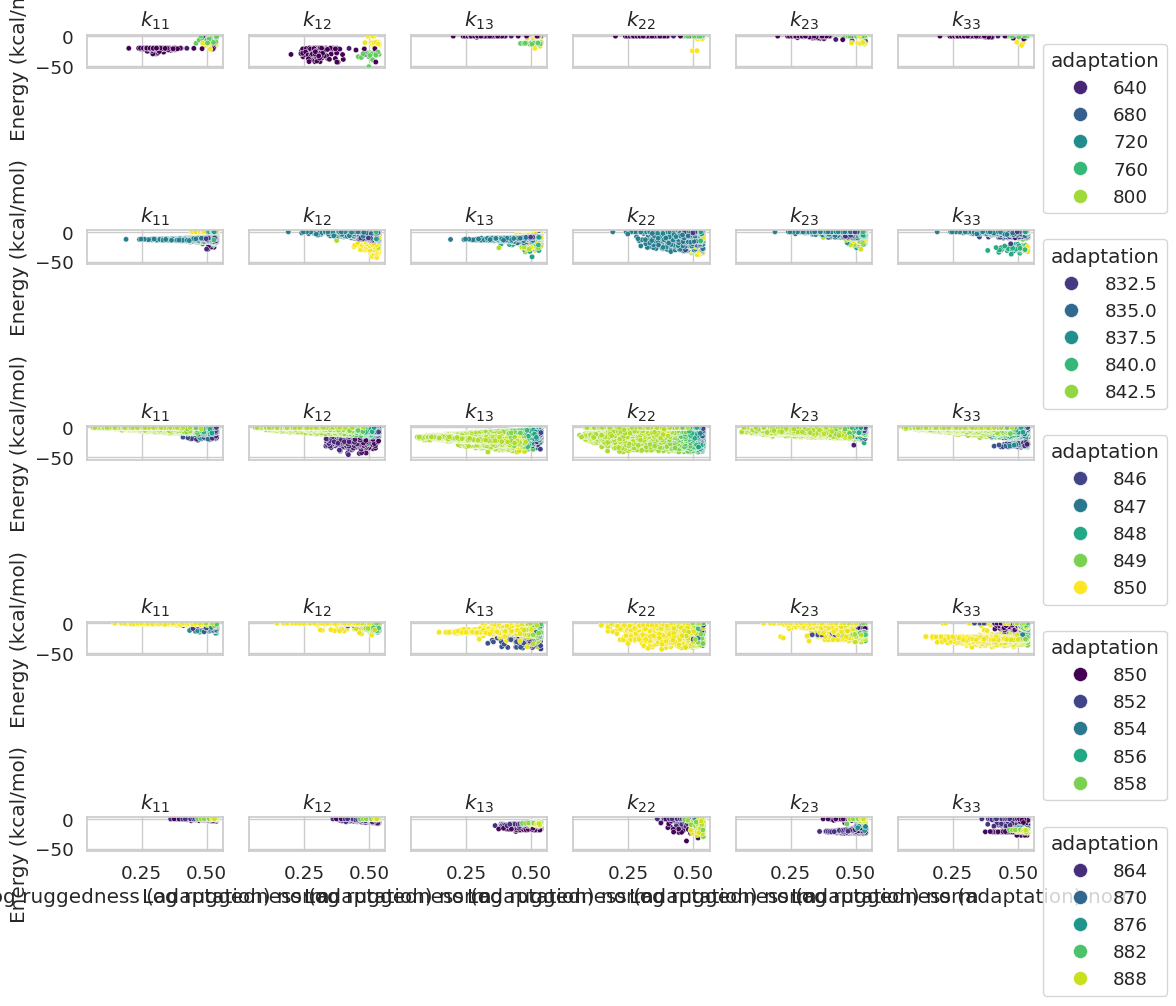

In [28]:
idx_perturbations_og = -1
assert all_fake_circuits.ndim == 4, 'Expected all_fake_circuits to be 4D: (n_samples, n_perturbs, n_species, n_species)'
df_rugg[cols_e] = make_sequence_from_symmetrical(
    all_fake_circuits[:, idx_perturbations_og, ...], side_length=n_species)

hue = 'adaptation'
x_col = 'Log ruggedness (Log sensitivity)'
x_col = 'Log sensitivity'
x_col = 'Log ruggedness (adaptation) norm'

filt = (df_rugg['Log ruggedness (Log sensitivity)'] < -1) & (
    df_rugg['Log ruggedness (Log precision)'] < -1)
filt = (df_rugg['Log ruggedness (adaptation)'] < 0)
splits = [610, 830, 845, 850, 860, 900]
fig, axs = plt.subplots(len(splits)-1, len(cols_e), figsize=(
    2*len(cols_e), 2*(len(splits)-1)), sharey=True, sharex=True)
for ii, split in enumerate(zip(splits[:-1], splits[1:])):
    for i, y_col in enumerate(cols_e):
        g = sns.scatterplot(df_rugg[filt & df_rugg[hue].between(*split)].sort_values(by='Is adaptable'),
                            x=x_col,
                            y=y_col, hue=hue,
                            palette='viridis', s=15, ax=axs[ii, i], legend=i == (len(cols_e) - 1))
        # g = sns.scatterplot(data[(data['sample_name'] == 'RNA_2') & (
        #     data['Log ruggedness (Log sensitivity)'] < -2) & (
        #     data['Log ruggedness (Log precision)'] < -2)].sort_values(by='Is adaptable'), x=x_col,
        #     y=y_col, hue=x_col,
        #     palette='viridis', s=15, ax=axs[ii, i], legend=i == (len(cols_e) - 1))

        if i == (len(cols_e) - 1):
            for line in g.legend().get_lines():
                line.set(alpha=1.0, markersize=10)
            g.legend_.set_title(hue)
            sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
        # axs[ii, i].set_xlabel(x_col.replace('Log', r'$Log_{10}$'))
        if i == 0:
            axs[ii, i].set_ylabel('Energy (kcal/mol)')
        axs[ii, i].set_title(y_col)

    plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'long_tail_energies.png'), dpi=300, bbox_inches='tight', transparent=True)

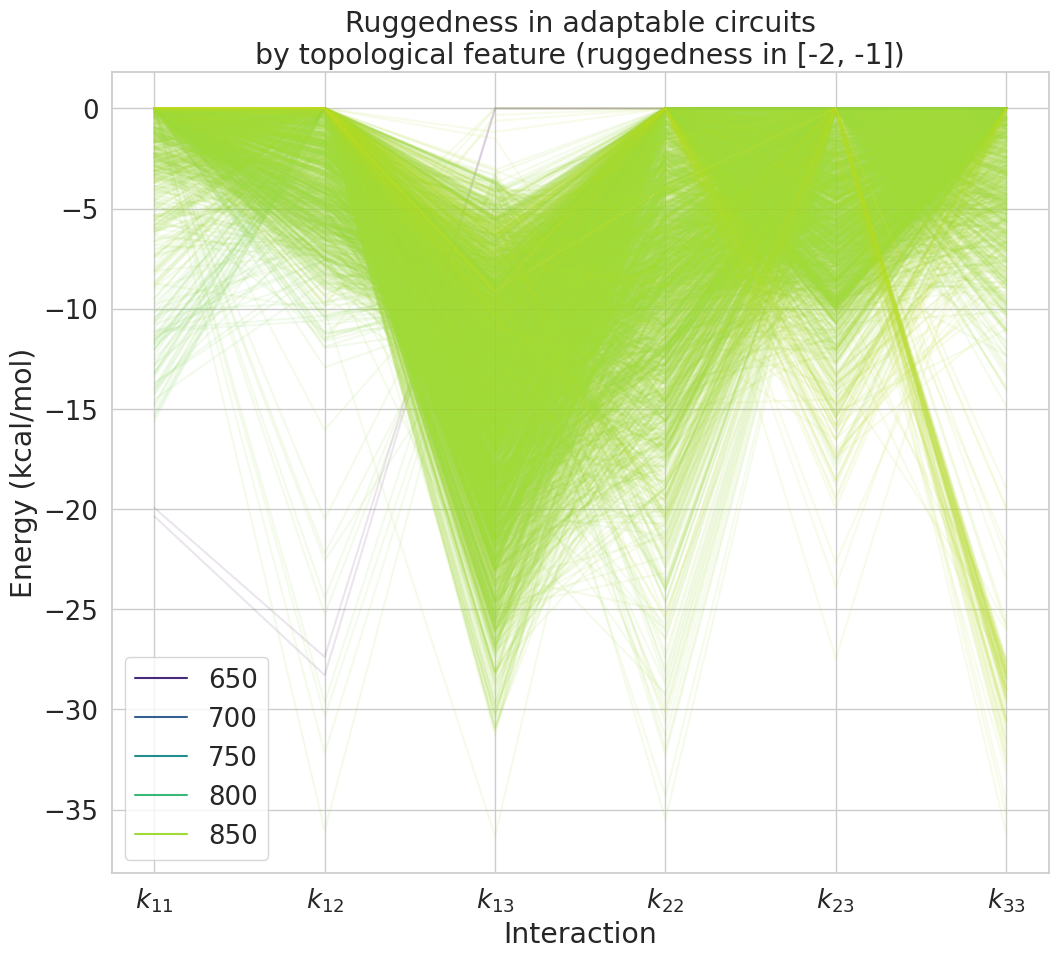

In [29]:
sns.set_context("notebook", font_scale=1.7)

n_show = int(1e4)
range_rugg_btwn = [-2, -1]
# dfm = data[(data['Log ruggedness (adaptation)'].between(*range_rugg_btwn)) & (data['sample_name'] == 'RNA_2')].melt(
filt = (df_rugg['Log ruggedness (adaptation)'] < 0) & (df_rugg.index.isin(np.array(
    jax.random.choice(jax.random.PRNGKey(0), np.arange(len(df_rugg)), shape=(n_show,), replace=False))))
dfm = df_rugg[filt].reset_index(drop=False).melt(
    id_vars=['index',
             'adaptation',
             'Log ruggedness (adaptation)',
             'Log ruggedness (adaptation) norm'],
    value_vars=cols_e, value_name='Energy (kcal/mol)', var_name='Interaction name').sort_values('Interaction name')
dfm['Interaction'] = dfm['Interaction name'].apply(
    lambda x: dict(zip(cols_e, np.arange(len(cols_e))))[x])

plt.figure(figsize=(11, 10))
hue = 'adaptation'
g = sns.lineplot(dfm.sort_values(by=hue, ascending=True),
                 x='Interaction', y='Energy (kcal/mol)',
                 #  hue='Log ruggedness (adaptation)', alpha=0.5,
                 hue=hue, alpha=0.1,
                 units='index', estimator=None,
                 palette='viridis')
for line in g.legend().get_lines():
    line.set(alpha=1.0, markersize=15)
# g.legend_.set_title(f'$Log_{{10}}$ Ruggedness')
plt.xticks(np.arange(len(cols_e)), cols_e)  # , rotation=45)

plt.title(
    f'Ruggedness in adaptable circuits\nby topological feature (ruggedness in {range_rugg_btwn})')
plt.tight_layout()